## IMPLEMENT A RNNS LANGUAGE MODEL FOR PREDICTING WORDS

### STEP 1: Import necessary libraries

In [15]:
import torch 
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import os
import requests
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from utils.build_vocab import Vocab
from utils.Trainer import RNNTrainer

%matplotlib inline

### STEP 2: Download and preprocessing dataset

2.1. Download data

In [16]:
print(os.getcwd())

d:\Program Files\VSCode\DL_self_practice\Recurrent_Neural_Networks


In [17]:
# Download dataset from a given url
url = "https://www.gutenberg.org/cache/epub/84/pg84.txt"
os.makedirs("../data", exist_ok=True)

response = requests.get(url)
filename = "../data/gutenberg_book.txt"

with open(filename, "w", encoding="utf-8") as f:
    f.write(response.text)

2.2. Preprocess data

In [18]:
# Preprocess the data, the trained tokens will be separate words
import re
with open(filename, "r", encoding="utf-8") as f:
    text = f.read()

text = re.sub('[^A-Za-z]+', ' ', text).lower()
words = text.split()

vocab = Vocab(words)
encoded = vocab[words]

2.3. Explore data

In [27]:
# Print the 10 most frequent words
freqs = vocab.token_freqs
for item in freqs[:10]:
    print(item)

('the', 4387)
('and', 3043)
('i', 2850)
('of', 2764)
('to', 2176)
('my', 1776)
('a', 1449)
('in', 1189)
('that', 1033)
('was', 1023)


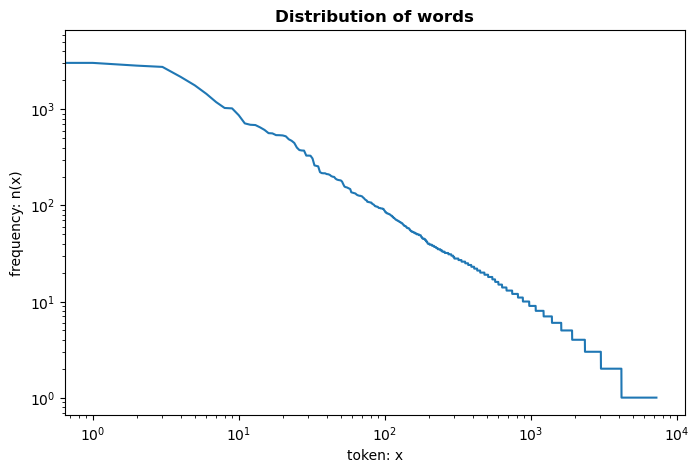

In [ ]:
# Show the distribution of words in text
freq = [freq for word, freq in freqs]
plt.figure(figsize=(8, 5))
plt.xlabel('token: x')
plt.ylabel('frequency: n(x)')
plt.xscale('log')
plt.yscale('log')
plt.title('Distribution of words', fontweight='bold')
plt.plot(freq)

### STEP 3: Build a specialize Dataset Class

In [19]:
class WordDataset(Dataset):
    def __init__(self, data, num_steps):
        self.data = data
        self.num_steps = num_steps

    # Number of samples
    def __len__(self):
        return len(self.data) - self.num_steps
    
    # Method to get samples based on index
    def __getitem__(self, index):
        x = self.data[index: index + self.num_steps]
        y = self.data[index + 1: index + self.num_steps + 1]
        return torch.tensor(x), torch.tensor(y)

Create dataloader which supports training

In [ ]:
num_steps = 10
num_epochs = 10
batch_size = 128
train_data, test_data = train_test_split(encoded, test_size=0.1, random_state=42)

train_dataset = WordDataset(train_data, num_steps)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

val_dataset = WordDataset(test_data, num_steps)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

### STEP 4: Build a language model based on RNNs

In [21]:
class LMRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dims, num_hiddens, num_layers=1):
        super(LMRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embedding_dims)
        self.rnn = nn.RNN(embedding_dims, num_hiddens, num_layers)
        self.fc = nn.Linear(num_hiddens, vocab_size)

    def forward(self, inputs, state=None):
        # input -> shape: (num_steps, batch_size)
        # x -> shape: (num_steps, batch_size, embedding_dims)
        x = self.embed(inputs)
        # out -> shape: (num_steps, batch_size, num_hiddens)
        # hn -> shape: (num_layers, batch_size, num_hiddens)
        out, hn = self.rnn(x, state)
        # y -> shape: (num_steps, batch_size, vocab_size)
        y = self.fc(out)
        return y, hn

### STEP 5: Training model

5.1. Set up parameters

In [22]:
vocab_size = len(vocab)
embedding_dims = 128
num_hiddens = 256
num_layers = 5
epochs = 10
gradient_clip_val = 1.0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LMRNN(vocab_size, embedding_dims, num_hiddens, num_layers).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.25)
criterion = nn.CrossEntropyLoss()
lr = 0.05

5.2. Create a trainer for training model

In [ ]:
trainer = RNNTrainer(model, vocab_size, train_loader, val_loader, lr, num_epochs, gradient_clip_val)

5.3. Start traing

In [ ]:
train_loss, test_loss = trainer.train_loss, trainer.val_loss
trainer.fit()

Training:  21%|██        | 113/551 [04:27<17:16,  2.37s/it]


KeyboardInterrupt: 

5.4. Showing train loss and test loss

In [ ]:
trainer.plot()
print(f'Training loss at the last epoch: {train_loss[-1]}')
print(f'Testing loss at the last epoch: {test_loss[-1]}')

### STEP 6: Build functions for predicting words

6.1. Build a function for predicting the next word

In [ ]:
def predict_next_word(model, start_text):
    model.eval()
    words = start_text.lower().split()
    inputs = torch.tensor(vocab[words], dtype=torch.long).to(device)
    # Converts inputs to (num_steps, batch_size=1)
    inputs = inputs.reshape(-1, 1)

    with torch.no_grad():
        y, _ = model(inputs)
        last_word_digits = y[-1, 0, :]
        predicted_idx = torch.argmax(last_word_digits).item()
        predicted_word = vocab.to_tokens(predicted_idx)
    return predicted_word

6.2. Build a function for predicting a sequence

In [ ]:
def predict_next_sequence(model, start_text, seq_len):
    model.eval()
    words = start_text.lower().split()
    inputs = torch.tensor(vocab[words], dtype=torch.long).to(device)
    inputs = inputs.reshape(-1, 1)

    with torch.no_grad():
        for _ in range(seq_len):
            out, _ = model(inputs)
            next_word_idx = torch.argmax(out[-1, 0, :]).item()
            next_word = vocab.to_tokens(next_word_idx)
            words.append(next_word)
            # Take 'seq_len' words in 'words' to feed into the model
            inputs = torch.tensor([vocab[w] for w in words[-num_steps:]], dtype=torch.long).reshape(-1, 1).to(device)
    
    return " ".join(words)

6.3. Implementing predictions

In [ ]:
prompt = "I was traveling around the city"
print(predict_next_word(model, prompt))
print(predict_next_sequence(model, prompt, 20))